# Data Cleaning and Understanding

In this file, all processes made to understand, and consequently clean the data for further usage are documented. An extensie descriptive 
analysis of each operation is present, and why those decisions were taken.

All original files are preserved in **basketballPlayoff** directory, and the cleaned files are on **basketballClean**, the current directory.

--- 

## Initial Analysis of Players and Team Data

Plots and statistics done in order to understand the data that will be used.

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

from py_helpers.db_helper import *

In [2]:
# Define the database name
database = './db/WNBA.db'
cleaned_data = './db/WNBA_cleared.db'
schemas = original_schema()

In [3]:
# Create the database and tables
table_info = create_db(database)

# Original .csv files
files = [
    '../basketballPlayoffs/awards_players.csv',
    '../basketballPlayoffs/coaches.csv',
    '../basketballPlayoffs/players_teams.csv',
    '../basketballPlayoffs/players.csv',
    '../basketballPlayoffs/series_post.csv',
    '../basketballPlayoffs/teams_post.csv',
    '../basketballPlayoffs/teams.csv'
]

# Load the data into the database
for i, table in enumerate(table_info.keys()):
    load_data_db(files[i], table, database)

# Original data loaded into the database

---
The group picked the "teams" data, a CSV file that contains data regarding teams in the WNBA league. Immediately, some columns / features appeared to be completely empty, and without any value to implicitly obtain the missing ones, they seemed useless for the prediction task. Other features, although no member could discern its value or meaning, contained values, so they were annotated for future analysis. 

In [4]:
# Load the Teams table into a DataFrame
teams_df = retrieve_data(database,'Teams')

# List of columns to remove
columns_to_remove = ['tmORB', 'tmDRB', 'tmTRB', 'opptmORB', 'opptmDRB', 'opptmTRB']
# Drop the specified columns from the DataFrame
teams_df.drop(columns=columns_to_remove, inplace=True)

In [5]:
# Remove unnecessary attributes from the Teams table
# Store the cleaned up schema of the Teams table

# Generate the new schema
new_schema = alter_schema_drop_columns(schemas['Teams'] , columns_to_remove)

# Insert the cleaned up data into the database
insert_dataframe(teams_df, 'Teams', cleaned_data, new_schema)

In [6]:
teams_df

,year,lgID,tmID,franchID,confID,divID,rank,playoff,seeded,firstRound,...,GP,homeW,homeL,awayW,awayL,confW,confL,min,attend,arena
0,9,WNBA,ATL,ATL,EA,,7,N,0,,...,34,1,16,3,14,2,18,6825,141379,Philips Arena
1,10,WNBA,ATL,ATL,EA,,2,Y,0,L,...,34,12,5,6,11,10,12,6950,120737,Philips Arena
2,1,WNBA,CHA,CHA,EA,,8,N,0,,...,32,5,11,3,13,5,16,6475,90963,Charlotte Coliseum
3,2,WNBA,CHA,CHA,EA,,4,Y,0,W,...,32,11,5,7,9,15,6,6500,105525,Charlotte Coliseum
4,3,WNBA,CHA,CHA,EA,,2,Y,0,L,...,32,11,5,7,9,12,9,6450,106670,Charlotte Coliseum
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,6,WNBA,WAS,WAS,EA,,5,N,0,,...,34,10,7,6,11,9,11,6900,171501,Verizon Center
138,7,WNBA,WAS,WAS,EA,,4,Y,0,L,...,34,13,4,5,12,12,8,6850,133255,Verizon Center
139,8,WNBA,WAS,WAS,EA,,5,N,0,,...,34,8,9,8,9,8,12,6900,133255,Verizon Center
140,9,WNBA,WAS,WAS,EA,,6,N,0,,...,34,6,11,4,13,6,14,6825,154637,Verizon Center


---
Regarding players information, a plot was created, to verify how many players each team contained, by grouping the number of unique players in each team

In [7]:
# Load the Players_Teams table into a DataFrame
df = retrieve_data(database, 'Players_Teams')

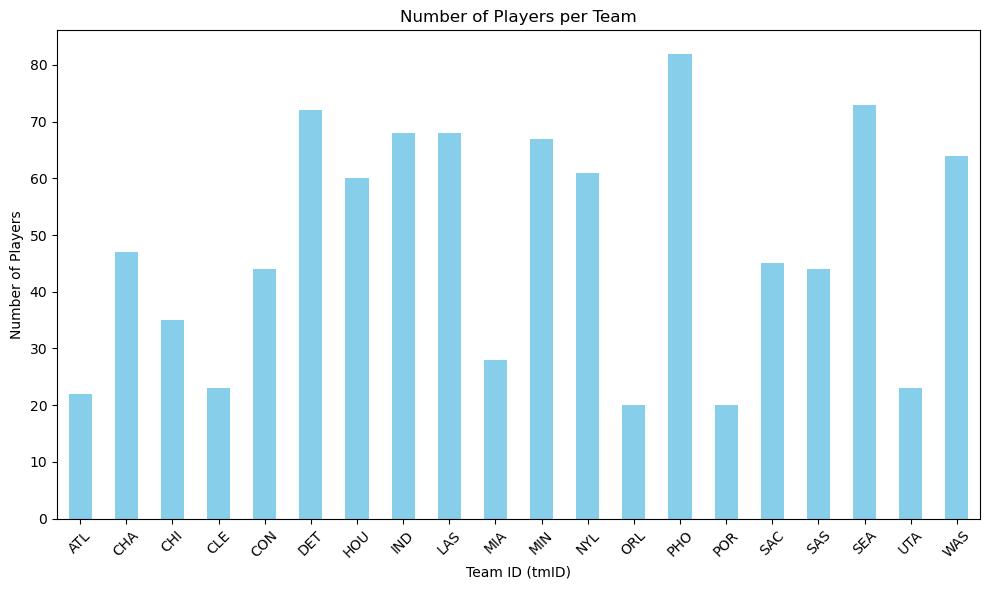

In [8]:
# Group the data by 'tmID' and count the number of unique 'playerID' in each group
grouped_data = df.groupby('tmID')['playerID'].nunique()

# Plot the grouped data
plt.figure(figsize=(10, 6))
grouped_data.plot(kind='bar', color='skyblue')
plt.xlabel('Team ID (tmID)')
plt.ylabel('Number of Players')
plt.title('Number of Players per Team')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

With this plot, the group was able to understand the distribution of players to each team. Although this initial analysis may not mean a lot in the final product, it helps the members get a grasp the magnitude of the set provided. 

---
Now, to try to verify a correlation between the number of players in each team, and the sum of points across the ten years of data, the following plot was created.

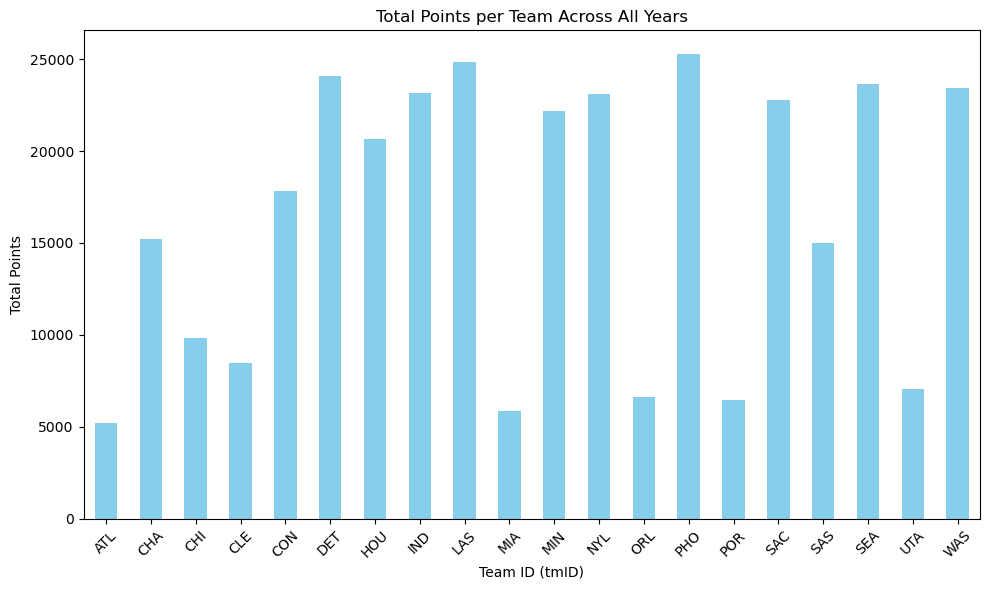

In [9]:
# Load the Players_Teams table into a DataFrame
player_teams_df = retrieve_data(database, 'Players_Teams')

# Group the data by 'tmID' and calculate the sum of points for each team
grouped_data = player_teams_df.groupby('tmID')['points'].sum()

# Plot the total points across all the years
plt.figure(figsize=(10, 6))
grouped_data.plot(kind='bar', color='skyblue')
plt.xlabel('Team ID (tmID)')
plt.ylabel('Total Points')
plt.title('Total Points per Team Across All Years')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Simply by comparing both plots, they almost overlay with each other, and although it was the expected outcome, it provided a way for the members to understand how they can use plot and analysis outcomes as valuable information for this project.


---
## General In-depth Analysis of Team Performance (across 10 years) 

In order to understand how the teams performed across the 10 years, a line graph was created, using the sum of all points scored for each team, divided by every year.
Unfortunately, having all teams on the same graph made it unreadable, and very cluttered.
To fix this, the teams data was separated in half, by the top 10 teams un summed points, in two different graphs.

Surprisingly, the lowest 10 teams in terms of total points, didn't play during the complete span of the 10 years, which made it very easy to understand why in a lot of fields, some teams posses null / zero values, across a large span of years.

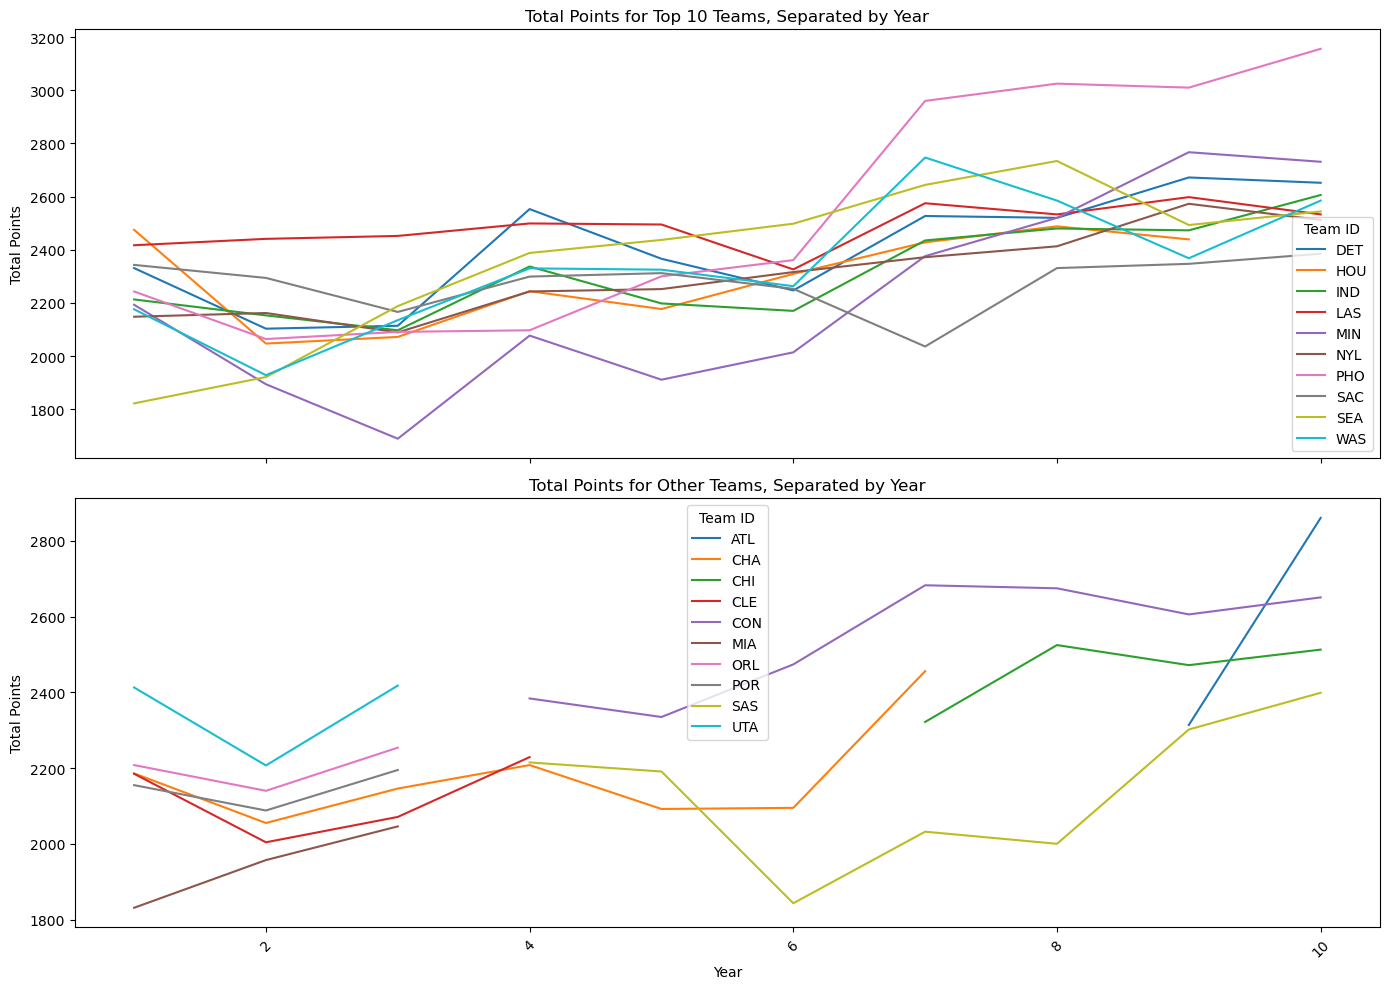

In [10]:
# Group the data by 'year' and 'tmID', then calculate the sum of points for each team in each year
grouped_data = player_teams_df.groupby(['year', 'tmID'])['points'].sum().reset_index()

# Get the top 10 teams with highest total points across all years
top_10_teams = grouped_data.groupby('tmID')['points'].sum().nlargest(10).index

# Separate the data for top 10 teams and others
top_10_teams_data = grouped_data[grouped_data['tmID'].isin(top_10_teams)]
other_teams_data = grouped_data[~grouped_data['tmID'].isin(top_10_teams)]

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), sharex=True)

# Plot total points for top 10 teams
for team_id, group in top_10_teams_data.groupby('tmID'):
    axes[0].plot(group['year'], group['points'], label=f'{team_id}')

axes[0].set_ylabel('Total Points')
axes[0].set_title('Total Points for Top 10 Teams, Separated by Year')
axes[0].legend(title='Team ID')

# Plot total points for other teams
for team_id, group in other_teams_data.groupby('tmID'):
    axes[1].plot(group['year'], group['points'], label=f'{team_id}')

axes[1].set_xlabel('Year')
axes[1].set_ylabel('Total Points')
axes[1].set_title('Total Points for Other Teams, Separated by Year')
axes[1].legend(title='Team ID')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

---

Even if the data from the playoffs (post) season won't be valuable to use to predict if a teams qualifies for them or not, using it it to understand the data was considered important.
To do so, the number of wins and losses in the post season was plotted, in individual line graphs for each teams, across the 10 year span. These graphs not only helped the group understand how the different teams performed, but how many times the played, or in other words, teams with longer line graphs (preferably crescent or at least not descendant) probably also perform better in the preseason (the won we try to predict). Also, the more data they have in these graphs, more probable the data influx keeps in next years.

In [11]:
# Load the Teams_Post table into a DataFrame
teams_post_df = retrieve_data(database, 'Teams_Post')

# Group the data by 'year' and 'teamID', then calculate the sum of wins ('W') and losses ('L') for each team in each year
grouped_data = teams_post_df.groupby(['year', 'tmID'])[['W', 'L']].sum().reset_index()

# Store the Teams_Post table in a new Database
insert_dataframe(teams_post_df, 'Teams_Post', cleaned_data, schemas['Teams_Post'])

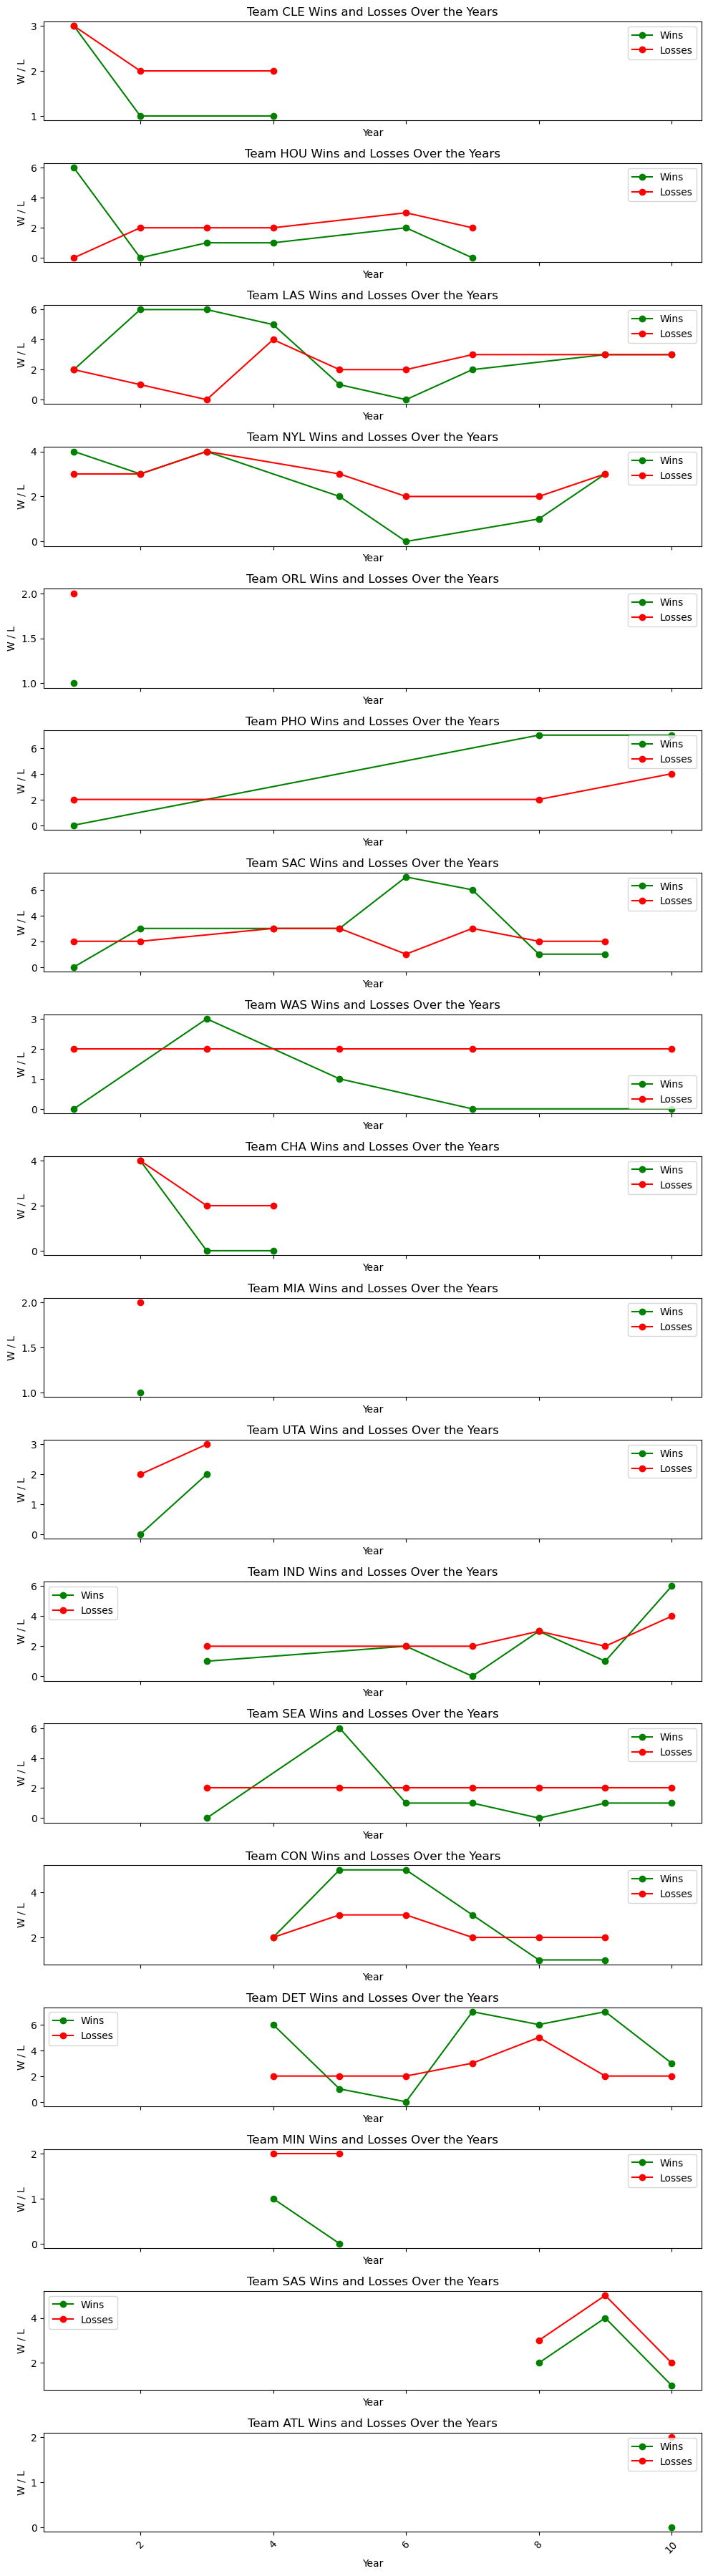

In [12]:
# Get unique team IDs
unique_teams = grouped_data['tmID'].unique()

# Create subplots for each team's wins and losses
fig, axes = plt.subplots(nrows=len(unique_teams), ncols=1, figsize=(10, 2 * len(unique_teams)), sharex=True)


# Plot wins and losses for each team
for i, team_id in enumerate(unique_teams):
    team_data = grouped_data[grouped_data['tmID'] == team_id]
    axes[i].plot(team_data['year'], team_data['W'], label='Wins', marker='o', color='green')
    axes[i].plot(team_data['year'], team_data['L'], label='Losses', marker='o', color='red')
    axes[i].set_title(f'Team {team_id} Wins and Losses Over the Years')
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('W / L')
    axes[i].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
# plt.savefig('wins_losses.png')

plt.show()

---
## Data Cleaning 

Now documented are some of the more complex data cleaning processes and tasks executed on data.

First, since the values seemed odd in a "naked eye" analyses, a plot to display player biological data (weight and height) was made.

In [13]:
players_df = retrieve_data(database, 'Players')
players_df.drop(columns=['firstseason','lastseason'], inplace=True)

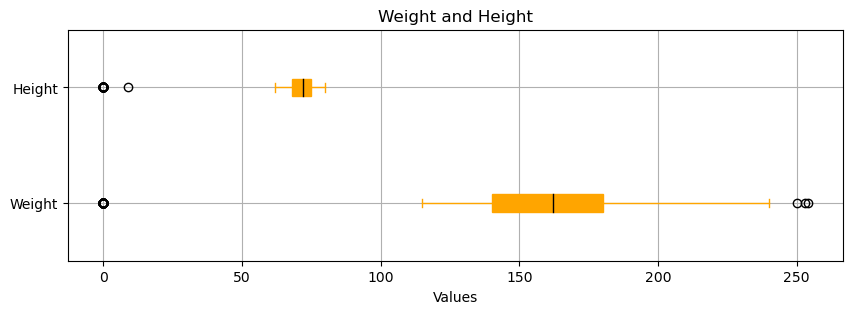

In [14]:
plt.figure(figsize=(10, 3))
players_df.boxplot(column=['weight', 'height'], vert=False, patch_artist=True, 
                         boxprops=dict(facecolor='orange', color='orange'), 
                         capprops=dict(color='orange'), whiskerprops=dict(color='orange'), 
                         medianprops=dict(color='black'), 
                         positions=[1, 2])
plt.title('Weight and Height')
plt.xlabel('Values')
plt.yticks([1, 2], ['Weight', 'Height'])
plt.show()

As it can be seen, there are very obvious erroneous outliers in both features, that should be clean (near the zero value).

First, by selecting the obvious wrong height values (bellow 50), the only entries returned are the following:

In [15]:
height_outliers = players_df[players_df['height'] < 50]
height_outliers

,bioID,pos,height,weight,college,collegeOther,birthDate,deathDate
5,adamsmi01w,,0.0,0,,,0000-00-00,0000-00-00
6,adubari99w,,0.0,0,,,0000-00-00,0000-00-00
7,aglerbr99w,,0.0,0,,,0000-00-00,0000-00-00
15,allenso99w,,0.0,0,,,0000-00-00,0000-00-00
52,beckan99wc,,0.0,0,,,0000-00-00,0000-00-00
...,...,...,...,...,...,...,...,...
848,willifr99w,,0.0,0,,,0000-00-00,0000-00-00
849,willigr99w,,0.0,0,,,0000-00-00,0000-00-00
863,wintebr01w,,0.0,0,,,0000-00-00,0000-00-00
872,woolror01w,,0.0,0,,,0000-00-00,0000-00-00


(If the values are not available, it's because they were overwritten in the base file, but their contest are explained in this block anyways)
As it can be seen, once again, the outliers values appear to be near the zero position, only for players in three field positions "C", "F", and "F-C".

In order to obtain new values to replace the errors, instead of making an average of the height of total players, it was decided to try to obtain more relevant values, that could represent real player data the best way possible. So an average of the height values, for each of said positions was calculated and applied.

In [16]:
centers_heights = round(players_df[players_df['pos'].isin(['C'])]['height'].mean(), 1)
forwards_centers_heights = round(players_df[players_df['pos'].isin(['F-C'])]['height'].mean(), 1)
forwards_heights = round(players_df[players_df['pos'].isin(['F'])]['height'].mean(), 1)

print(f'Average height of centers: {centers_heights} inches')
print(f'Average height of forwards/centers: {forwards_centers_heights} inches')
print(f'Average height of forwards: {forwards_heights} inches')

Average height of centers: 75.7 inches
Average height of forwards/centers: 74.1 inches
Average height of forwards: 73.1 inches


In [17]:
# Find height outliers for each position
height_outliers_centers = players_df[(players_df['pos'] == 'C') & (players_df['height'] < 50)]
height_outliers_forwards_centers = players_df[(players_df['pos'] == 'F-C') & (players_df['height'] < 50)]
height_outliers_forwards = players_df[(players_df['pos'] == 'F') & (players_df['height'] < 50)]

In [18]:
height_outliers_centers.loc[:, 'height'] = centers_heights
height_outliers_forwards_centers.loc[:, 'height'] = forwards_centers_heights
height_outliers_forwards.loc[:, 'height'] = forwards_heights

players_df.update(height_outliers_centers)
players_df.update(height_outliers_forwards_centers)
players_df.update(height_outliers_forwards)

C:\Users\janto\AppData\Local\Temp\ipykernel_15928\4153917223.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  height_outliers_centers.loc[:, 'height'] = centers_heights
C:\Users\janto\AppData\Local\Temp\ipykernel_15928\4153917223.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  height_outliers_forwards_centers.loc[:, 'height'] = forwards_centers_heights
C:\Users\janto\AppData\Local\Temp\ipykernel_15928\4153917223.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [19]:
players_df = players_df.loc[~((players_df['weight'] == 0) & (players_df['height'] == 0))]

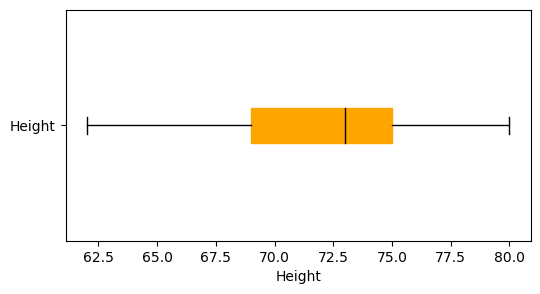

In [20]:
plt.figure(figsize=(6, 3))
plt.boxplot(players_df['height'], vert=False, patch_artist=True,  boxprops=dict(facecolor='orange', color='orange'), medianprops=dict(color='black') )
plt.xlabel('Height')
plt.yticks([1], ['Height'])
plt.show()

As the boxplot shows, the values now possess no outliers.

---

To tackle the weight problem, since the outlier values (apart from the ones near zero) did not seem that outlandish, it was decided not to remove / replace them from the set. But since they are still considered outliers, they were not considered to be used in the calculation of the average weight for the "wrong" near zero data. Instead, using the previous weight boxplot as basis, the average of the inter-quartile (Q3 - Q1) was calculated and applied.

In [21]:
weight_outliers = players_df[players_df['weight'] ==  0]

weight_outliers

,bioID,pos,height,weight,college,collegeOther,birthDate,deathDate
10,alberma01w,G,64.0,0.0,Ohio State,,1975-04-12,0000-00-00
33,ayimmi01w,F,75.0,0.0,Pepperdine,,1988-05-06,0000-00-00
56,berezva01w,C,76.0,0.0,Rice,,1986-04-10,0000-00-00
66,bishoab01w,F-C,74.0,0.0,,,1988-11-29,0000-00-00
92,brancli01w,G,64.0,0.0,Texas A&M,,0000-00-00,0000-00-00
136,cartesy01w,G,66.0,0.0,Texas A&M,,1990-11-18,0000-00-00
161,clarkma01w,F-C,75.0,0.0,Arizona,,1971-01-01,0000-00-00
189,cunnima01w,F-C,76.0,0.0,Vanderbilt,,1973-05-20,0000-00-00
203,davista02w,G,71.0,0.0,Florida State,,1987-06-07,0000-00-00
210,dixonin01w,C,75.0,0.0,California,,1972-09-16,0000-00-00


In [22]:
Q1 = players_df['weight'].quantile(0.25)
Q3 = players_df['weight'].quantile(0.75)
IQR = Q3 - Q1

In [23]:
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [24]:
mean_weight_iqr = round(players_df[
    (players_df['weight'] >= lower_bound) & (players_df['weight'] <= upper_bound)
]['weight'].mean())

In [25]:
players_df.loc[players_df['weight'] == 0, 'weight'] = mean_weight_iqr


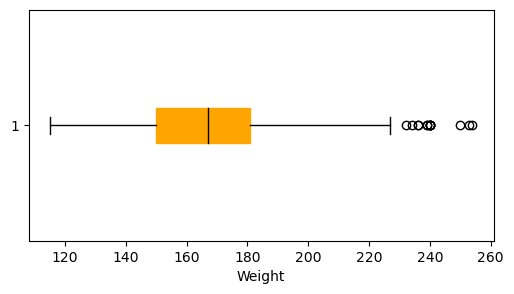

In [26]:
plt.figure(figsize=(6, 3))
plt.boxplot(players_df['weight'], vert=False, patch_artist=True, boxprops=dict(facecolor='orange', color='orange'), medianprops=dict(color='black'))
plt.xlabel('Weight')
plt.show()

Again, there are still outliers, but as the team learned, not every one is an error, because real life has inconsistencies.

---

The following data cleaning tasks were simpler, referring to normalization of null / empty values regarding college and otherCollege values:

In [27]:
college_none_entries = players_df[players_df['college'].str.lower() == 'none']
college_none_entries

,bioID,pos,height,weight,college,collegeOther,birthDate,deathDate
26,arcaija01w,G,71.0,147.0,none,,1969-04-11,0000-00-00
28,askamma01w,C,77.0,198.0,none,,1970-08-07,0000-00-00
98,brcanra01w,C,80.0,198.0,none,,1967-04-15,0000-00-00
128,camba01w,C,80.0,215.0,none,,1991-08-18,0000-00-00
142,cebriel01w,C,77.0,190.0,none,,1971-02-07,0000-00-00
550,morrizi01w,C,76.0,167.0,none,,1989-02-15,0000-00-00
607,petroso01w,F,73.0,167.0,none,,1989-02-18,0000-00-00
805,veselja01w,F,75.0,195.0,none,,1983-12-31,0000-00-00


In [28]:
empty_college_entries = players_df[players_df['college'].isnull()]
players_df['college'].fillna('none', inplace=True)

In [29]:
empty_college_entries = players_df[players_df['college'].isnull()]
empty_college_entries 

,bioID,pos,height,weight,college,collegeOther,birthDate,deathDate


In [30]:
empty_other_college_entries = players_df[players_df['collegeOther'].isnull()]
players_df['collegeOther'].fillna('none', inplace=True)

In [31]:
empty_other_college_entries = players_df[players_df['collegeOther'].isnull()]
empty_other_college_entries

,bioID,pos,height,weight,college,collegeOther,birthDate,deathDate


In [32]:
# Store the cleaned up data into the database
insert_dataframe(players_df, 'Players', cleaned_data, schemas['Players'])

---

## More Analysis and Feature Engineering

More analysis were considered necessary, now regarding the other tables / files, in this section, mainly related to coach data.

First, an histogram of the coaches accumulated win / losses across the years was plotted, to try to verify who were the "best" ones.

In [33]:
coaches_df = retrieve_data(database, 'Coaches')

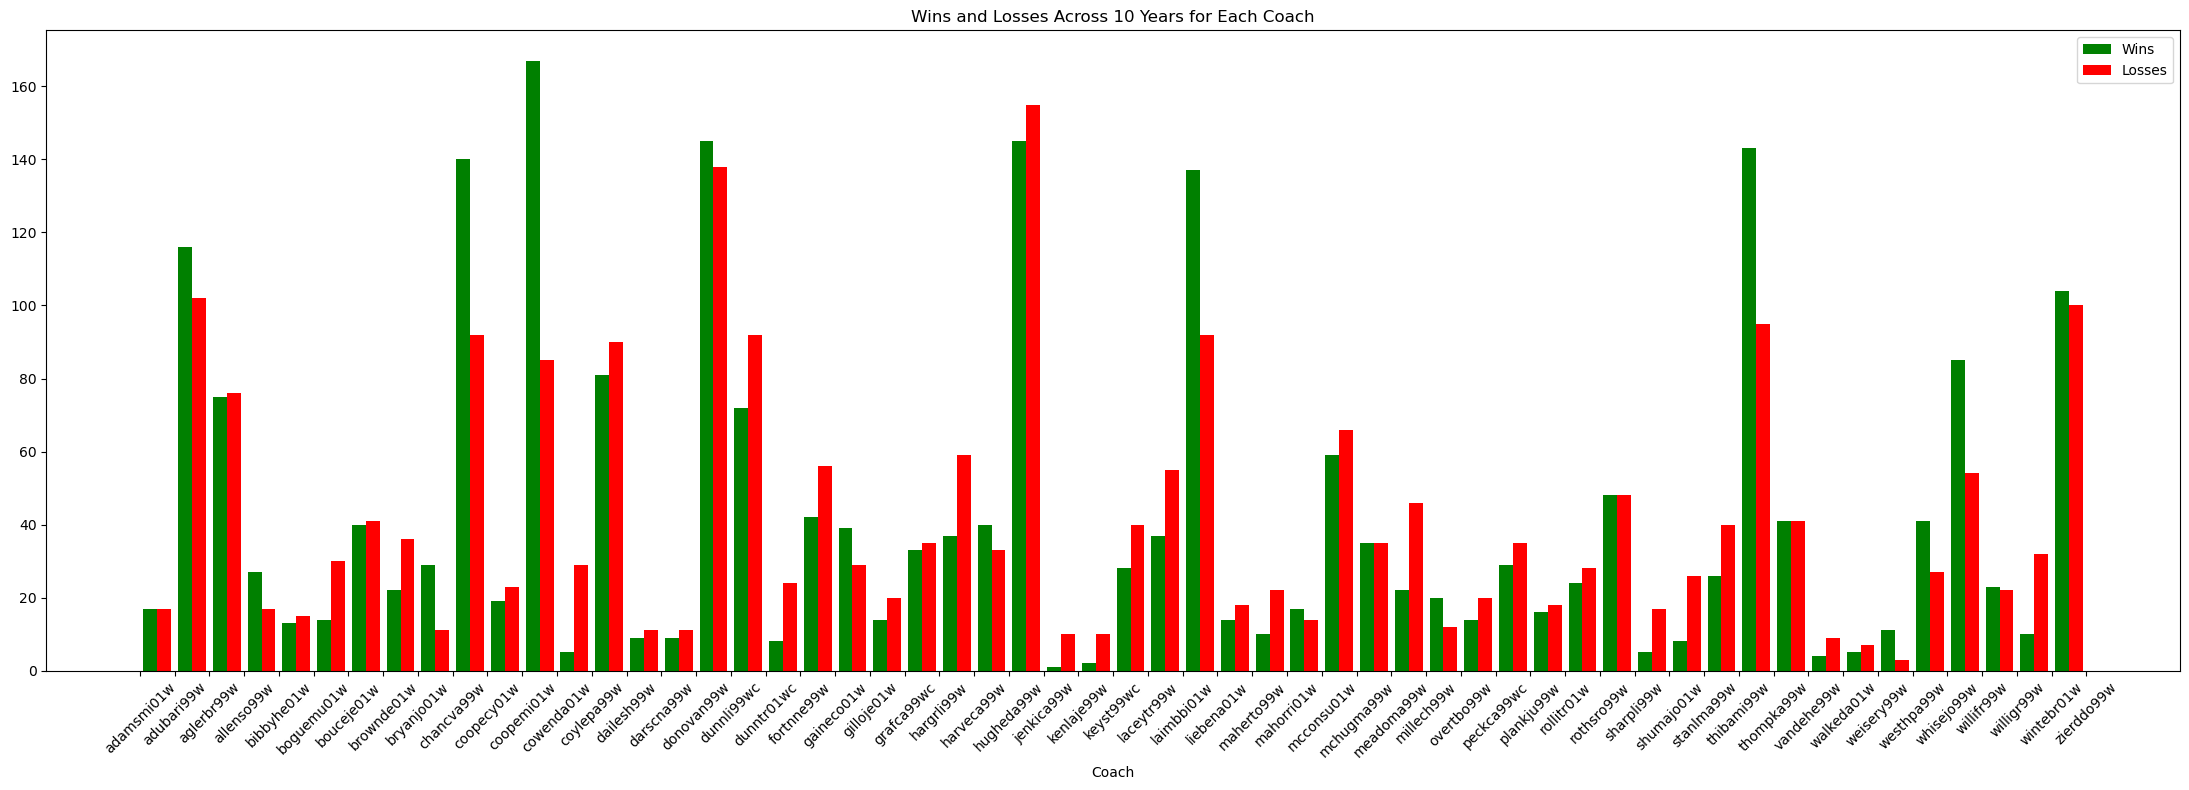

In [34]:
grouped_data = coaches_df.groupby('coachID')[['won', 'lost']].sum()

plt.figure(figsize=(22, 8))

bins = range(len(grouped_data))

plt.hist([bins, bins], bins=bins, weights=[grouped_data['won'], grouped_data['lost']], color=['green', 'red'], label=['Wins', 'Losses'])
plt.xlabel('Coach')
plt.xticks(bins, grouped_data.index)
plt.xticks(rotation=45)
plt.title('Wins and Losses Across 10 Years for Each Coach')
plt.legend(['Wins', 'Losses'])
plt.tight_layout()
plt.show()

Then, the same was made to the Post / Playoff season, to verify if the performance was maintained (only the ones whose teams made it to the post season are present in the following plot)

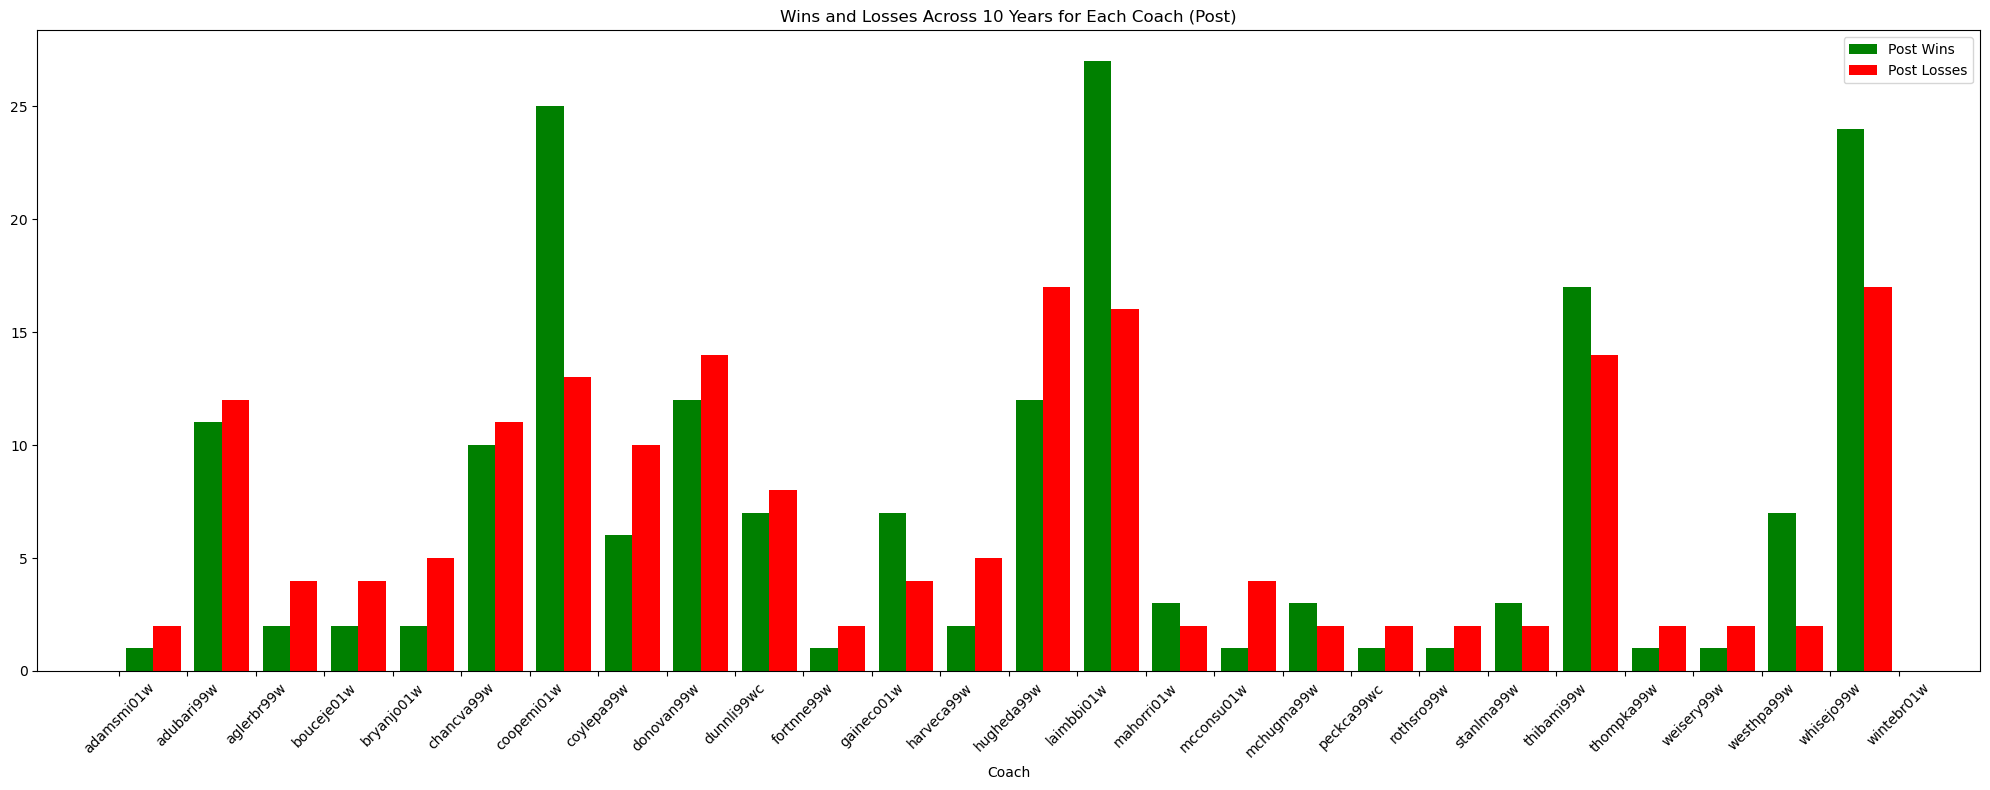

In [35]:
grouped_data = coaches_df.groupby('coachID')[['post_wins', 'post_losses']].sum()

plt.figure(figsize=(20, 8))

post_grouped = grouped_data[(grouped_data['post_wins'] > 0) & (grouped_data['post_losses'] > 0)]

bins = range(len(post_grouped))

plt.hist([bins, bins], bins=bins, weights=[post_grouped['post_wins'], post_grouped['post_losses']], color=['green', 'red'], label=['Post Wins', 'Post Losses'])
plt.xlabel('Coach')
plt.xticks(bins, post_grouped.index)
plt.xticks(rotation=45)
plt.title('Wins and Losses Across 10 Years for Each Coach (Post)')
plt.legend(['Post Wins', 'Post Losses'])
plt.tight_layout()
plt.show()

As expected, the best coaches from the pre seasons (by best, the team considers most wins or best win / loss ratio) were also the best in the playoffs 

---

To create new features, based on the discoveries, further analysis was needed.

Again, we picked the "best" top 5 coaches on the list ("we could use the post season file, because they were the same), and aggregated them, with sum of win values. 

In [36]:
coaches_df['total_wins'] = coaches_df['won'] + coaches_df['post_wins']

grouped_data = coaches_df.groupby('coachID')['total_wins'].sum()

top_5_coaches = grouped_data.nlargest(5)
top_5_coaches

coachID
coopemi01w    192
laimbbi01w    164
thibami99w    160
donovan99w    157
hugheda99w    157
Name: total_wins, dtype: int64

Then, a list containing the teams they coached was created

In [37]:
teams_by_top_coaches = coaches_df[coaches_df['coachID'].isin(top_5_coaches.index)]['tmID'].unique()
list(teams_by_top_coaches)

['LAS', 'IND', 'CHA', 'SEA', 'NYL', 'CLE', 'SAS', 'DET', 'CON']

Then, for those teams, the number of wins in the post season was verified, sumed, and presented, to see what teams performed best in the playoffs

In [38]:
teams_post_df = retrieve_data(cleaned_data, 'Teams_Post')

teams_with_top_coaches_W = teams_post_df[teams_post_df['tmID'].isin(teams_by_top_coaches)].groupby('tmID')['W'].sum()

teams_with_top_coaches_W.sort_values(ascending=False)

tmID
DET    30
LAS    28
CON    17
NYL    17
IND    13
SEA    10
SAS     7
CLE     5
CHA     4
Name: W, dtype: int64

Now, since the "post" tables data may not be very valuable to train a model based on wether a team enters the playoffs or not, the group tried to verify if the previously obtained results (performance in the post / playoffs season) match the values from the preseason (performance in the preseason tables)

So, the number of times a team got into the playoffs (the model's target variable), was put in a table, to compare with previous results:

In [39]:
teams_df = retrieve_data(cleaned_data, 'Teams')

teams_with_playoff_status_Y = teams_df[(teams_df['tmID'].isin(teams_by_top_coaches)) & (teams_df['playoff'] == 'Y')]
teams_with_playoff_status_Y.groupby('tmID').count()["playoff"].sort_values(ascending=False)

tmID
LAS    9
DET    7
NYL    7
SEA    7
CON    6
IND    6
CHA    3
CLE    3
SAS    3
Name: playoff, dtype: int64

As it can be scene, the expected outcome was reality, because both cases present similar ordering of the same teams, which indicates that even if the post data is not relevant to the model directly, collateral useful information can be obtained, by creating new features using those values, since the performance maintains coherence.

---

Now a sum of the points each player scored was put into a table, ordering them in descending order

In [40]:
players_teams_df = retrieve_data(database, 'Players_Teams')
grouped_points = players_teams_df.groupby('playerID')['points'].sum()
#players with most points across all 10 years
top20_players_points = grouped_points.nlargest(20)
top20_players_points

playerID
jacksla01w    5101
smithka01w    5096
leslili01w    4769
thompti01w    4762
catchta01w    4047
tauradi01w    4029
hammobe01w    4000
nolande01w    3971
smithta01w    3932
holdsch01w    3798
lennobe01w    3785
griffyo01w    3693
mcwilta01w    3674
douglka01w    3641
miltode01w    3626
salesny01w    3518
swoopsh01w    3502
melvich01w    3378
birdsu01w     3238
johnsvi01w    3193
Name: points, dtype: int64

And then, for those top scoring players, a list of every team they played was created.
It was visible that if a player performance (scoring) was really good, they wouldn't change teams very often, which happened with mid-tier players

In [41]:
top20_players = players_teams_df[players_teams_df['playerID'].isin(top20_players_points.index)]
tmID_values = top20_players.groupby('playerID')['tmID'].unique().apply(list).reset_index()

#change the order to top20 palyers
top20player_list = list(top20_players_points.index)
tmID_values['playerID'] = pd.Categorical(tmID_values['playerID'], categories=top20player_list, ordered=True)

tmID_values_sorted = tmID_values.sort_values(by='playerID')
tmID_values_sorted.reset_index(inplace=True, drop=True)
tmID_values_sorted

,playerID,tmID
0,jacksla01w,[SEA]
1,smithka01w,"[MIN, DET]"
2,leslili01w,[LAS]
3,thompti01w,"[HOU, LAS]"
4,catchta01w,[IND]
5,tauradi01w,[PHO]
6,hammobe01w,"[NYL, SAS]"
7,nolande01w,[DET]
8,smithta01w,"[SAC, CHA, PHO]"
9,holdsch01w,"[WAS, LAS, ATL]"


A table that seemed since the beginning that its data wouldn't be very valuable was the one containing awards players / coaches received, but it wasn't totally ignored, without a simple analysis.

In [42]:
awards_df = retrieve_data(database, 'Awards_Players')

more_awards = awards_df['playerID'].value_counts().head(10)
more_awards

leslili01w    10
swoopsh01w     8
catchta01w     5
tauradi01w     4
jacksla01w     4
thibami99w     2
parkeca01w     2
lennobe01w     2
staleda01w     2
coopecy01w     2
Name: playerID, dtype: int64

It was easy to understand that the players that performed the best (verified in the previous analysis) would be the same as the ones with most awards.

To try to obtain more knowledge from them, the teams they played in were put in a list, and checked if those teams were also frequently playoff season participants.

In [43]:
tmID_values_sorted[tmID_values_sorted['playerID'].isin(list(more_awards.index))]

,playerID,tmID
0,jacksla01w,[SEA]
2,leslili01w,[LAS]
4,catchta01w,[IND]
5,tauradi01w,[PHO]
10,lennobe01w,"[MIN, MIA, CLE, SEA, ATL, LAS]"
16,swoopsh01w,"[HOU, SEA]"


In [44]:
# get unique values for teams with players with more awards
flattened_list = [i for sublist in list(tmID_values_sorted.tmID) for i in sublist]
unique_elements = list(set(flattened_list))
unique_elements

['IND',
 'CHA',
 'ORL',
 'LAS',
 'SAC',
 'SEA',
 'MIN',
 'WAS',
 'CON',
 'HOU',
 'CHI',
 'PHO',
 'SAS',
 'MIA',
 'CLE',
 'DET',
 'ATL',
 'NYL']

In [45]:
best_teams_playoff_status_Y = teams_df[(teams_df['tmID'].isin(unique_elements)) & (teams_df['playoff'] == 'Y')]
best_teams_playoff_status_Y.groupby('tmID').count()["playoff"].sort_values(ascending=False)

tmID
LAS    9
SAC    8
DET    7
NYL    7
SEA    7
CON    6
HOU    6
IND    6
WAS    5
SAS    3
CLE    3
CHA    3
PHO    3
MIN    2
ATL    1
ORL    1
MIA    1
Name: playoff, dtype: int64

As it was expected, the suspicion of the group was confirmed. By bringing back the previous ("number of times the best coaches teams went to playoffs") table, its visible that the teams on top are still the same. So surprisingly, even if the tables don't seem very interesting at the beginning, they can always contain valuable data.

In [46]:
#teams with best coaches (again for comparing)
teams_with_playoff_status_Y.groupby('tmID').count()["playoff"].sort_values(ascending=False)

tmID
LAS    9
DET    7
NYL    7
SEA    7
CON    6
IND    6
CHA    3
CLE    3
SAS    3
Name: playoff, dtype: int64

---

### New Table Feature Engineering 

To finish this section, by following the professor's advice, a new table was created, in which new features were created and added, to be joined in the training process of the model, to the main "teams" table.


Since the training process can be made using different approaches, where "windows" of data are going to be selected at a time (regarding the years selected for each epoch). For the new columns two variants were always created:
 1. The total sum of a value for the team, during each year.
 2. The cumulative sum of a value for a year, regarding all the previous years too.

In [47]:
teams_df = retrieve_data(cleaned_data, 'Teams')

# Initialize an empty list to store data for all teams
team_data_list = []

for team in teams_df['tmID'].unique():
    # Create a DataFrame with 10 rows for the current team
    team_data = pd.DataFrame({'year': list(range(1, 11)),'tmID': [team] * 10})
    # Append the team data to the list
    team_data_list.append(team_data)

# Concatenate data for all teams into a single DataFrame
all_teams_data = pd.concat(team_data_list, ignore_index=True)
#all_teams_data.set_index('year', inplace=True)

teams_year_df = all_teams_data

In [48]:
players_teams_df = retrieve_data(database, 'Players_Teams')

team_year_points = players_teams_df.groupby(['tmID', 'year'])['points'].sum().reset_index()
# Iterate over unique 'tmID' values
for tmID in team_year_points['tmID'].unique():
    cumulative_sums = []
    cumulative_sum = 0
    for year in range(1, 11):
        year_sum = team_year_points.loc[(team_year_points['tmID'] == tmID) & (team_year_points['year'] == year), 'points'].sum()
        cumulative_sum += year_sum
        teams_year_df.loc[(teams_year_df['tmID'] == tmID) & (teams_year_df['year'] == year), 'cumulativePoints'] = cumulative_sum
        cumulative_sums.append(cumulative_sum)
    print(f"tmID: {tmID}, Cumulative Sums of Points: {cumulative_sums}")

teams_year_df['cumulativePoints'] = teams_year_df['cumulativePoints'].round().astype(int)


tmID: ATL, Cumulative Sums of Points: [0, 0, 0, 0, 0, 0, 0, 0, 2314, 5175]
tmID: CHA, Cumulative Sums of Points: [2186, 4241, 6387, 8595, 10687, 12782, 15238, 15238, 15238, 15238]
tmID: CHI, Cumulative Sums of Points: [0, 0, 0, 0, 0, 0, 2322, 4847, 7319, 9832]
tmID: CLE, Cumulative Sums of Points: [2185, 4189, 6260, 8489, 8489, 8489, 8489, 8489, 8489, 8489]
tmID: CON, Cumulative Sums of Points: [0, 0, 0, 2384, 4719, 7193, 9876, 12551, 15157, 17808]
tmID: DET, Cumulative Sums of Points: [2331, 4434, 6548, 9101, 11467, 13714, 16241, 18761, 21433, 24085]
tmID: HOU, Cumulative Sums of Points: [2475, 4522, 6594, 8838, 11015, 13324, 15752, 18240, 20679, 20679]
tmID: IND, Cumulative Sums of Points: [2213, 4366, 6463, 8800, 10998, 13168, 15603, 18083, 20556, 23162]
tmID: LAS, Cumulative Sums of Points: [2417, 4858, 7310, 9809, 12304, 14630, 17205, 19738, 22336, 24869]
tmID: MIA, Cumulative Sums of Points: [1831, 3788, 5834, 5834, 5834, 5834, 5834, 5834, 5834, 5834]
tmID: MIN, Cumulative Sums o

In [49]:
players_teams_df = retrieve_data(database, 'Players_Teams')

team_year_points = players_teams_df.groupby(['tmID', 'year'])['points'].sum().reset_index()

# Iterate over unique 'tmID' values
for tmID in team_year_points['tmID'].unique():
    year_sums = []
    for year in range(1, 11):
        year_sum = team_year_points.loc[(team_year_points['tmID'] == tmID) & (team_year_points['year'] == year), 'points'].sum()
        year_sums.append(year_sum)
        teams_year_df.loc[(teams_year_df['tmID'] == tmID) & (teams_year_df['year'] == year), 'totalPoints'] = year_sum


    print(f"tmID: {tmID}, Yearly Sums of Points: {year_sums}")

teams_year_df['totalPoints'] = teams_year_df['totalPoints'].round().astype(int)

tmID: ATL, Yearly Sums of Points: [0, 0, 0, 0, 0, 0, 0, 0, 2314, 2861]
tmID: CHA, Yearly Sums of Points: [2186, 2055, 2146, 2208, 2092, 2095, 2456, 0, 0, 0]
tmID: CHI, Yearly Sums of Points: [0, 0, 0, 0, 0, 0, 2322, 2525, 2472, 2513]
tmID: CLE, Yearly Sums of Points: [2185, 2004, 2071, 2229, 0, 0, 0, 0, 0, 0]
tmID: CON, Yearly Sums of Points: [0, 0, 0, 2384, 2335, 2474, 2683, 2675, 2606, 2651]
tmID: DET, Yearly Sums of Points: [2331, 2103, 2114, 2553, 2366, 2247, 2527, 2520, 2672, 2652]
tmID: HOU, Yearly Sums of Points: [2475, 2047, 2072, 2244, 2177, 2309, 2428, 2488, 2439, 0]
tmID: IND, Yearly Sums of Points: [2213, 2153, 2097, 2337, 2198, 2170, 2435, 2480, 2473, 2606]
tmID: LAS, Yearly Sums of Points: [2417, 2441, 2452, 2499, 2495, 2326, 2575, 2533, 2598, 2533]
tmID: MIA, Yearly Sums of Points: [1831, 1957, 2046, 0, 0, 0, 0, 0, 0, 0]
tmID: MIN, Yearly Sums of Points: [2193, 1894, 1689, 2077, 1911, 2014, 2376, 2520, 2767, 2731]
tmID: NYL, Yearly Sums of Points: [2148, 2162, 2089, 2243

As said, the total per year, as the cumulative value of the points feature was created and added to the new table.

In [50]:
players_teams_df = retrieve_data(database, 'Players_Teams')

team_year_minutes = players_teams_df.groupby(['tmID', 'year'])['minutes'].sum().reset_index()

# Iterate over unique 'tmID' values
for tmID in team_year_minutes['tmID'].unique():
    year_sums = []
    for year in range(1, 11):
        year_sum = team_year_minutes.loc[(team_year_minutes['tmID'] == tmID) & (team_year_minutes['year'] == year), 'minutes'].sum()
        year_sums.append(year_sum)
        teams_year_df.loc[(teams_year_df['tmID'] == tmID) & (teams_year_df['year'] == year), 'totalMinutes'] = year_sum


    print(f"tmID: {tmID}, Minutes Played: {year_sums}")

teams_year_df['totalMinutes'] = teams_year_df['totalMinutes'].round().astype(int)

tmID: ATL, Minutes Played: [0, 0, 0, 0, 0, 0, 0, 0, 6364, 6951]
tmID: CHA, Minutes Played: [6475, 6500, 6058, 6806, 6900, 6945, 6825, 0, 0, 0]
tmID: CHI, Minutes Played: [0, 0, 0, 0, 0, 0, 6800, 6975, 6875, 6674]
tmID: CLE, Minutes Played: [6500, 6425, 6550, 6825, 0, 0, 0, 0, 0, 0]
tmID: CON, Minutes Played: [0, 0, 0, 6875, 6900, 6800, 6827, 6924, 6477, 6976]
tmID: DET, Minutes Played: [6425, 6550, 6450, 6900, 6850, 6925, 6825, 6402, 6875, 6976]
tmID: HOU, Minutes Played: [6475, 6450, 6425, 6825, 6850, 6875, 6651, 6698, 6560, 0]
tmID: IND, Minutes Played: [6425, 6475, 6425, 6875, 6850, 6925, 6850, 6874, 6952, 6924]
tmID: LAS, Minutes Played: [6450, 6475, 6475, 6900, 6975, 6800, 6825, 6900, 7002, 6925]
tmID: MIA, Minutes Played: [6475, 6575, 6475, 0, 0, 0, 0, 0, 0, 0]
tmID: MIN, Minutes Played: [6425, 5750, 5452, 5729, 5872, 6092, 6153, 6377, 6901, 6874]
tmID: NYL, Minutes Played: [6425, 6400, 6450, 6850, 6900, 6925, 6876, 6851, 6901, 6902]
tmID: ORL, Minutes Played: [6500, 6450, 6525, 

In [51]:
# Save table Teams_Year to the database
schemas['Teams_Year'] = 'Create Table Teams_Year (year int, tmID text, cumulativePoints int, totalPoints int, totalMinutes int, primary key (year, tmID), foreign key (tmID) references Teams(tmID))'
insert_dataframe(teams_year_df, 'Teams_Year', cleaned_data, schemas['Teams_Year'])

As said, the total per year, as the cumulative value of the points feature was created and added to the new table.

---

Now, by selecting values from the yearly wins and losses for each teams, in the "coaches.csv" file, they could be added to the newly created table, after aggregating the values by team and year.

In [52]:
coaches_df = retrieve_data(database, 'Coaches')
coach_wins = coaches_df.groupby(['year', 'tmID'])['won'].sum().reset_index()
coach_loss = coaches_df.groupby(['year', 'tmID'])['lost'].sum().reset_index()

In [53]:
merged_df = pd.merge(teams_year_df, coach_wins, on=['tmID', 'year'], how='left')
merged_df = pd.merge(merged_df, coach_loss, on=['tmID', 'year'], how='left')

# Rename the 'won' column to 'yearlyWins', and 'lost' to 'yearlyLoss'
merged_df.rename(columns={'won': 'yearlyWins'}, inplace=True)
merged_df.rename(columns={'lost': 'yearlyLosses'}, inplace=True)

merged_df['yearlyWins'] = merged_df['yearlyWins'].round().fillna(0).astype(int)
merged_df['yearlyLosses'] = merged_df['yearlyLosses'].round().fillna(0).astype(int)

#merged_df.to_csv('teams_year.csv',index=False)
merged_df

,year,tmID,cumulativePoints,totalPoints,totalMinutes,yearlyWins,yearlyLosses
0,1,ATL,0,0,0,0,0
1,2,ATL,0,0,0,0,0
2,3,ATL,0,0,0,0,0
3,4,ATL,0,0,0,0,0
4,5,ATL,0,0,0,0,0
...,...,...,...,...,...,...,...
195,6,WAS,13157,2263,6900,16,18
196,7,WAS,15904,2747,6850,18,16
197,8,WAS,18489,2585,6891,16,18
198,9,WAS,20857,2368,6825,10,24


In [54]:
# Save table Teams_Year to the database
schemas['Teams_Year'] = 'Create Table Teams_Year (year int, tmID text, totalPoints int, cumulativePoints int, totalMinutes int, yearlyWins int, yearlyLosses int, primary key (year, tmID), foreign key (tmID) references Teams(tmID))'
insert_dataframe(merged_df, 'Teams_Year', cleaned_data, schemas['Teams_Year'])

---

Since the coach is also a very important feature for a team's performance, the coach value for the year (the coach the team had during a specific year) was also added.

In [55]:
coaches_df = retrieve_data(database, 'Coaches')
grouped_coaches = coaches_df.groupby(['tmID', 'year'])['coachID'].first().reset_index()

In [56]:
grouped_coaches

,tmID,year,coachID
0,ATL,9,meadoma99w
1,ATL,10,meadoma99w
2,CHA,1,dunntr01wc
3,CHA,2,donovan99w
4,CHA,3,donovan99w
...,...,...,...
137,WAS,6,adubari99w
138,WAS,7,adubari99w
139,WAS,8,adubari99w
140,WAS,9,kenlaje99w


In [57]:
teams_year_df = retrieve_data(cleaned_data, 'Teams_Year')

merged_df = pd.merge(teams_year_df, grouped_coaches, on=['tmID', 'year'], how='left')

merged_df.fillna('none', inplace=True)

In [58]:
# Save table Teams_Year to the database
schemas['Teams_Year'] = 'Create Table Teams_Year (year int, tmID text, totalPoints int, cumulativePoints int, totalMinutes int, yearlyWins int, yearlyLosses int, coachID text, primary key (year, tmID), foreign key (tmID) references Teams(tmID), foreign key (coachID) references Coaches(coachID))'
insert_dataframe(merged_df, 'Teams_Year', cleaned_data, schemas['Teams_Year'])

After saving the coach value, a new process was needed to be done on the same data, called **getting dummy data**.
Basically, since the models the group is planning to use (e.g. RandomForestClassifier) do not have the capability to deal with string data, or in other words, categorical data. So, the get_dummies() function allows the feature selected to become N different new features, one for each of the possible values, and then, each entry (row), needs only to fill the column correspondent to the previous feature value with a 1. This way, there is the possibility to convert all categorical values to integer or boolean.

**(NOTE)**
*A similar process was executed in some other features, mainly the target variable "playoff" in the "teams.csv" file, however, since the possible values were only two, being in this case, Y or N, a simple conversion to boolean (1 / 0) was enough, removing the need to create new features, and increasing dimensionality*

In [59]:
team_year_df = retrieve_data(cleaned_data, 'Teams_Year')

dummies = pd.get_dummies(team_year_df['coachID'], prefix='coach')

dummies_integers = dummies.astype(int)

df_with_dummies = pd.concat([team_year_df, dummies_integers], axis=1)

df_with_dummies.drop('coachID', axis=1, inplace=True)

In [60]:
schema = schema_builder(df_with_dummies)
schemas['Teams_Year'] = f"Create Table Teams_Year ({schema}, primary key (year, tmID), foreign key (tmID) references Teams(tmID))"
insert_dataframe(df_with_dummies, 'Teams_Year', cleaned_data, schemas['Teams_Year'])

In [61]:
awards_df = retrieve_data(database, 'Awards_Players')

awards_dummies = pd.get_dummies(awards_df['award'])

awards_dummies_integers = awards_dummies.astype(int)

awards_df_with_dummies = pd.concat([awards_df, awards_dummies_integers], axis=1)

awards_df_with_dummies.drop('award', axis=1, inplace=True)


# Replace spaces with underscores in the column names
awards_df_with_dummies.columns = awards_df_with_dummies.columns.str.replace(' ', '_')
awards_df_with_dummies.columns = awards_df_with_dummies.columns.str.replace('-', '_')


In [62]:
schema = schema_builder(awards_df_with_dummies)
schemas['Awards_Players'] = f"Create Table Awards_Players ({schema}, foreign key (playerID) references Players(playerID))"
insert_dataframe(awards_df_with_dummies, 'Awards_Players', cleaned_data, schemas['Awards_Players'])

To further decrease dimensionality, some variables / features were combined, by creating ratios, as exemplified bellow

In [63]:
players_teams_df = retrieve_data(database, 'Players_Teams')


players_teams_df['threeRatio'] = players_teams_df['threeMade'] / players_teams_df['threeAttempted']

players_teams_df.drop(['threeMade', 'threeAttempted'], axis=1, inplace=True)

In [64]:
team_p_df = players_teams_df.round(2)

team_p_df.fillna(0, inplace=True)

# Reorder columns with 'threeRatio' before 'dq'
column_order = list(team_p_df.columns)
column_order.remove('threeRatio')  # Remove 'threeRatio' from the list of columns
column_order.insert(column_order.index('dq'), 'threeRatio')  # Insert 'threeRatio' before 'dq'


team_p_df = team_p_df[column_order]

In [65]:
schema = schema_builder(team_p_df)
schemas['Players_Teams'] = f"Create Table Players_Teams ({schema}, foreign key (playerID) references Players(playerID), foreign key (tmID) references Teams(tmID))"
insert_dataframe(team_p_df, 'Players_Teams', cleaned_data, schemas['Players_Teams'])

In [66]:
players_teams_df = retrieve_data(cleaned_data, 'Players_Teams')

players_teams_df['ftRatio'] = players_teams_df['ftMade'] / players_teams_df['ftAttempted']

players_teams_df.drop(['ftMade', 'ftAttempted'], axis=1, inplace=True)
team_p_df = players_teams_df.round(2)


team_p_df.fillna(0, inplace=True)

column_order = list(team_p_df.columns)
column_order.remove('ftRatio')  
column_order.insert(column_order.index('threeRatio'), 'ftRatio')  


team_p_df = team_p_df[column_order]

In [67]:
schema = schema_builder(team_p_df)
schemas['Players_Teams'] = f"Create Table Players_Teams ({schema}, foreign key (playerID) references Players(playerID), foreign key (tmID) references Teams(tmID))"
insert_dataframe(team_p_df, 'Players_Teams', cleaned_data, schemas['Players_Teams'])

In [68]:
player_teams_df = retrieve_data(cleaned_data, 'Players_Teams')

players_teams_df['fgRatio'] = players_teams_df['fgMade'] / players_teams_df['fgAttempted']

players_teams_df.drop(['fgMade', 'fgAttempted'], axis=1, inplace=True)
team_p_df = players_teams_df.round(2)


team_p_df.fillna(0, inplace=True)

column_order = list(team_p_df.columns)
column_order.remove('fgRatio')  
column_order.insert(column_order.index('ftRatio'), 'fgRatio')  


team_p_df = team_p_df[column_order]

In [69]:
schema = schema_builder(team_p_df)
schemas['Players_Teams'] = f"Create Table Players_Teams ({schema}, foreign key (playerID) references Players(playerID), foreign key (tmID) references Teams(tmID))"
insert_dataframe(team_p_df, 'Players_Teams', cleaned_data, schemas['Players_Teams'])

In [70]:
# Pass the data that wasnt cleaned up during this process
copy_missing_tables(database, cleaned_data)